## Demystifying the mathematics behind PCA

We all know PCA and we all love PCA. Our friend that helps us deal with the curse of dimensionality. All data scientists have probably used [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). I thought I knew PCA.

Until I was asked to explain the mathematics behind PCA in an interview and all I could murmur was that it somehow maximizes the variance of the new features. The interviewer was even kind enough to throw me a hint about projections. To my chagrin, I couldn't figure it out even then and had to admit I was stumped. To rub salt in my wounds, I knew that I was taught the mathematics behind PCA during the first year of my Master's course. So here's a post to make sure that doesn't happen to you, dear reader, and hopefully me as well.  

WARNING: This post will be long and mathematical as the title suggests.

<hr>

## Introducing PCA

PCA stands for Principal Component Analysis. If you have multidimensional data that's giving you a hard time when you try to train a model on it, PCA could be the answer. You could also visualize high dimensional data using PCA, which is done often in [NLP](https://necromuralist.github.io/Neurotic-Networking/posts/nlp/pca-dimensionality-reduction-and-word-vectors/index.html).

In [87]:
# there's no understanding without doing, so let's write some code
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import random
sns.set_style("darkgrid")
from sklearn.datasets import load_wine
np.random.seed(420)

We have a set of data, that we will call $x$. $x$ is $(k,m)$ dimensional, hence every point in $x$ will be such that $x_i \in \mathbb{R}^m$ (just a fancy way of saying we pick any point from x and that point is a real number in $m$ dimensions). We have $k$ such $m$ dimensional points. Our goal is to represent $x$ in less than $m$ dimensions. This is by no means going to be a perfect transition. Say we project down from $m$ dimensions to $n$ dimensions. By definition, $n<m$.

In [17]:
# say D=10, i.e we have 10 dimensional data.
x = np.random.rand(10,10)
# for the geeks amongst us this is from a continuous uniform distrbution from [0, 1)
x.shape
# so we have 10 (k=10) data points each of which have 10 dimensions (m=10)

(10, 10)

The typical approach is to maximize the variance of the $n$ dimensional data in such a way that it captures as much of the variance of the $m$ dimensional data as possible. Let's call $z$ the co-ordinates of the projection of $x$ into the lower $n$ dimensional space.

[Harold Hotelling](https://en.wikipedia.org/wiki/Harold_Hotelling) is credited with coming up with the idea of minimizing the variance in 1933. Mr.Hotelling was quite the madlad, since he also came up with the T-square distribution amongst other laws, lemmas and rules. He wrote presciently in his original paper, 90 years ago: 
>"It is natural to ask whether some more fundamental set of independent variables exists, perhaps fewer in number than the $x$'s, which determine the values the $x$'s will take."

<hr>

## Gentle math

Let's introduce the mean. This is our "average" friend.
$$\bar{x}=\frac{1}{n}\sum_{i}^{n}x_i$$

In [18]:
# in numpy if we don't define the axis
# it will compute the mean of all the 100 elements that we entered
x.mean()

0.48955083684170964

In [19]:
# since we're dealing with components,
# we are more interested in the columwise or featurewise mean
x.mean(axis=0)

array([0.50299989, 0.46627609, 0.62990129, 0.5188987 , 0.43764572,
       0.59755813, 0.48329069, 0.47277132, 0.46266469, 0.32350185])

In [20]:
# if you're paranoid and you'd like to check the values, here you go:
for i in range(0,10):
    print(x[:,i].sum()/10)

0.5029998856345316
0.4662760922130609
0.6299012923571106
0.5188986993892943
0.4376457212611754
0.5975581266463694
0.48329069068570707
0.47277132022054413
0.46266468509761466
0.3235018549116885


### Standard deviation

The standard deviation is just how much each point deviates from the mean. It measures how spread out our data is. Standard deviation is denoted as $\sigma$.

$$\sigma=\sqrt{\frac{1}{n}\sum_{i}^{n}(x_i - \bar{x})^2}$$

In [21]:
x.std(axis=0)

array([0.25282779, 0.31208093, 0.24974188, 0.31661173, 0.30802279,
       0.25662288, 0.1512335 , 0.22761326, 0.22715909, 0.3097734 ])

In [22]:
# say we have some different data:
y = np.array([1]*6)
z = np.array([0]*3+[1]*3)
w = np.arange(1,7)
arrays = [y, z, w]

In [23]:
# we can check their means:
for _ in arrays:
    print(_.mean())

1.0
0.5
3.5


In [24]:
# we can also check their standard deviation:
for _ in arrays:
    print(_.std())

0.0
0.5
1.707825127659933


In [25]:
# paranoia tax
for _ in arrays:
    current_mean = _.mean()
    print(np.sqrt(np.sum((_ - current_mean)**2)/len(_)))

0.0
0.5
1.707825127659933


This makes sense when you consider that our array y had only one value and has a standard deviation of 0. Our array z was slightly more spread out, but still it only had 2 unique values each occuring thrice. Our array w was the most numerically diverse of y, z and w, and hence it had the highest standard deviation.

### Variance

The variance is simply the square of the standard deviation.

$$ var(x) = \sigma^2=\frac{1}{n}\sum_{i}^{n}(x_i - \bar{x})^2$$

In [26]:
x.var(axis=0)

array([0.06392189, 0.09739451, 0.06237101, 0.10024299, 0.09487804,
       0.06585531, 0.02287157, 0.0518078 , 0.05160125, 0.09595956])

In [27]:
# consider the 1d line data again
for _ in arrays:
    print(_.var())

0.0
0.25
2.9166666666666665


All the measures we looked at so far were dealing with only one dimension. Notice that we have just one number to describe the mean, $\sigma$ and $\sigma^2$ for our one-liner data (y,z,w), since they contain only one dimension. However, we had to specify an axis for $x$, since $x$ is a collection of 10 data points with 10 dimensions each. Also notice that when dealing with $x$, all 3 measures had 10 values, that is as many values as the number of dimensions in $x$.

### Covariance

To figure out the interactions between the dimensions and how they vary depending on each other, we introduce the aptly named covariance term. The covariance is always measured between two dimensions. Notice the similarities between the variance and the covariance below:

$$ var(x) \frac{1}{n}\sum_{i}^{n}(x_i - \bar{x})(x_i - \bar{x})$$

$$ cov(x,y) = \frac{1}{n}\sum_{i}^{n}(x_i - \bar{x})(y_i - \bar{y})$$

It might be nice to see the covariance of variable on a real dataset rather than the random data we have here:

In [28]:
# toy data from the wine sklearn dataset
from sklearn.datasets import load_wine
data = load_wine()["data"]
data.shape
# we have 13 features

(178, 13)

Covariance can only capture the variance between <b>2</b> variables. Additionally, we also know that the covarince of a feature with itself is the variance. As far as a count of covariances goes, in this case with 13 features, we will have a 13x13 matrix, since there 12 other features to compare with and one of the feature compared with itself (variance). All of the above mental gymnastics just allows us to express covariance a matrix. The covariance matrix is usually denoted by $\Sigma$.

In [14]:
# features are in columns, hence rowvar is false
np.cov(data, rowvar=False).shape

(13, 13)

In [15]:
np.cov(data, rowvar=False)

array([[ 6.59062328e-01,  8.56113090e-02,  4.71151590e-02,
        -8.41092903e-01,  3.13987812e+00,  1.46887218e-01,
         1.92033222e-01, -1.57542595e-02,  6.35175205e-02,
         1.02828254e+00, -1.33134432e-02,  4.16978226e-02,
         1.64567185e+02],
       [ 8.56113090e-02,  1.24801540e+00,  5.02770393e-02,
         1.07633171e+00, -8.70779534e-01, -2.34337723e-01,
        -4.58630366e-01,  4.07333619e-02, -1.41146982e-01,
         6.44838183e-01, -1.43325638e-01, -2.92447483e-01,
        -6.75488666e+01],
       [ 4.71151590e-02,  5.02770393e-02,  7.52646353e-02,
         4.06208278e-01,  1.12293658e+00,  2.21455913e-02,
         3.15347299e-02,  6.35847140e-03,  1.51557799e-03,
         1.64654327e-01, -4.68215451e-03,  7.61835841e-04,
         1.93197391e+01],
       [-8.41092903e-01,  1.07633171e+00,  4.06208278e-01,
         1.11526862e+01, -3.97476036e+00, -6.71149146e-01,
        -1.17208281e+00,  1.50421856e-01, -3.77176220e-01,
         1.45024186e-01, -2.09118054e

Positive covariance values between two features indicate that as one feature increases the other also increases. Negative values indicate an increase-decrease relation.

The 13x13 matrix might be a little hard to visualize, so let's look at a covariance matrix with just 4 features, $a, b, c, d$:
$$
\Sigma = \begin{bmatrix}
cov(a,a) & cov(a,b) & cov(a,c) & cov(a,d) \\\\
cov(b,a) & cov(b,b) & cov(b,c) & cov(b,d) \\\\
cov(c,a) & cov(c,b) & cov(c,c) & cov(c,d) \\\\
cov(d,a) & cov(d,b) & cov(d,c) & cov(d,d) \\
\end{bmatrix}
$$

### Proof that the covariance matrix is symmetric
$$cov(a,b) = cov(b,a)$$
This is quite easy to prove, consider:
$$ cov(a,b) = \frac{1}{n}\sum_{i}^{n}(a_i - \bar{a})(b_i - \bar{b})$$
$$ cov(b,a) = \frac{1}{n}\sum_{i}^{n}(b_i - \bar{b})(a_i - \bar{a})$$
We know that multiplication is commutative, i.e. $ab = ba$. This makes the covariance matrix a symmetric matrix.😁

<hr>

## Serious math

Let's talk about matrices and their products. We can multiple two matrices $\mathbf{A}$ with dimensions (x,y) and $\mathbf{B}$, with dimensions (u,v), if and only if, y = u, i.e. the number of columns in $\mathbf{A}$ is the same as the number of rows in $\mathbf{B}$. The matrix product itself in this case will be (x,v) dimensional.

In [16]:
# let's say I have two matrices and I try to multiply them:
a = np.random.rand(10,10)
b = np.random.rand(10,20)
a.dot(b).shape

(10, 20)

Every linear transformation $T: \mathbb{R}^m \rightarrow \mathbb{R}^n$ can be represented as matrix. Going from $m$ to $n$ dimensions? I bet that sounds kinda familiar. PCA is nothing but a linear transformation.
<hr>

### Eigenvalues and Eigenvectors

Say we have a vector $x$ and a matrix $\mathbf{A}$. Almost all vectors change direction when multipled by a matrix, i.e. they point in a different direction. When this multiplication with a matrix does not change the direction of $x$, then $x$ is called an eigenvector.
$$\mathbf{A}x = \lambda x$$
$\lambda$ is the eigenvalue of the matrix $\mathbf{A}$. While $\mathbf{A}$ may not change the direction of x, it does change the magnitude. The eigenvalue $\lambda$ tells us whether $\mathbf{A}$ increased / decreased / did neither vis-a-vis the magnitude of the eigenvector $x$.

### Eigenvalues visualized

Right now, we kind of understand when we can multiply two matrices. The same principles apply when we're multiplying a matrix with a vector.

In [36]:
# for instance:
matrix1 = np.random.rand(3,3)
vector1 = np.random.rand(3,1)
# we can multiply matrix1 and vector1 because: (3x3)x(3x1), 
# both the inner dimensions are the same just as in the
# matrix to matrix multiplication
matrix1.dot(vector1)

array([[0.52496104],
       [1.01737068],
       [1.03492964]])

I found I daresay my favorite example and demonstration of this concept in book called "The Manga Guide to Linear Algebra". With thanks, I'll be using the same example as the book.  
We know that we can multiply vectors and matrices under a certain condition on their dimensions. But what happens when we multiply a matrix and a vector?

In [47]:
# Consider the following two vectors:
vector1 = np.array([3, 1]) # represents the point, x=3, y=1
vector2 = np.array([1, 2]) # represents the point x=1, y=2

In [62]:
np.array([vector1, vector2])

array([[3, 1],
       [1, 2]])

In [88]:
def plot_vectors(list_of_vectors):
    # https://saturncloud.io/blog/how-to-plot-vectors-in-python-using-matplotlib-a-guide-for-data-scientists/
    fig, ax = plt.subplots()
    # colors = list("bgrcmy")
    for vector in list_of_vectors:
        ax.quiver(0, 0, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color=random.choice(list(mcolors.TABLEAU_COLORS.values())
))
    xlim = max(np.array(list_of_vectors).max(axis=0))
    ylim = max(np.array(list_of_vectors).max(axis=1))
    ax.set_xlim([-xlim-1, xlim+1])
    ax.set_ylim([-ylim-1, ylim+1])
    # plt.grid()
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    plt.title("Figure 1: Initial vectors")
    plt.show()

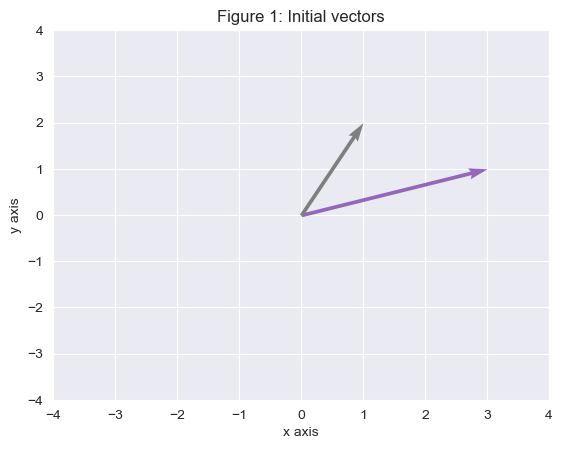

In [89]:
plot_vectors([vector1, vector2])

In [77]:
# say we multiply these vectors by a 2x2 matrix
matrix1 = np.array([[8, -3],[2, 1]])
matrix1

array([[ 8, -3],
       [ 2,  1]])

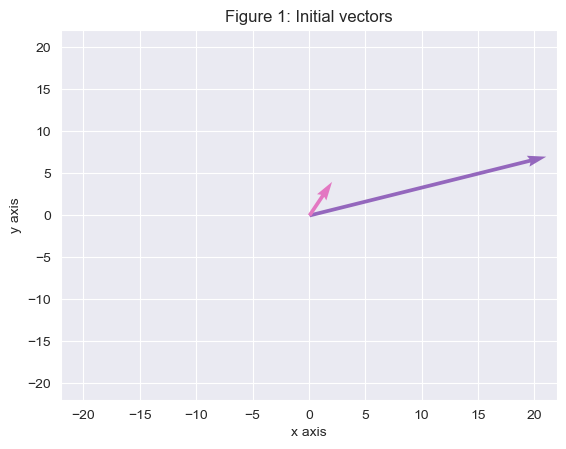

In [90]:
transformed_vector1 = matrix1.dot(vector1)
transformed_vector2 = matrix1.dot(vector2)
plot_vectors([transformed_vector1, transformed_vector2])
# we can see that the matrix has changed the initial vectors

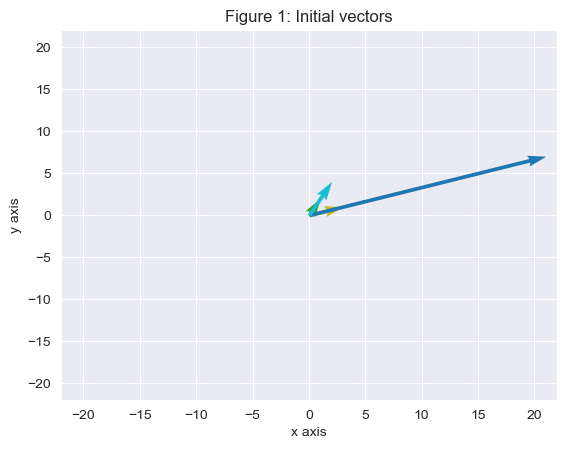

In [91]:
plot_vectors([vector1, vector2, transformed_vector1, transformed_vector2])

The rotation is more evident when we look at a plane. Borrowing an example from the book (follow the fish):

Initially, the vectors look like:  
![Initial Vectors](image.png)

After the matrix multiplication, the vectors look like:  
![Vectors after transformation](image-1.png)

There's something interesting to notice in the graphs and the pictures. Notice that the plane rotates when we transform it linearly (multiply a matrix). Interestingly, the two vectors that we chose, didn't rotate at all. This means all points on the original fish that were not on the lines shown in images were not just extended, but also rotated. However, the points on the two lines / vectors were just extended. That's because they're special vectors with respect to this transformation (with respect to this matrix). These two vectors are the eigenvectors of the matrix, as multiplying them by the matrix given only changes their magnitude and not their direction. Which provides some intuition as to why we have:
$$\mathbf{A}x = \lambda x$$

When we have eigenvectors of the form shown in the graphs and pictures, we have eigenvalues associated with them. Eigenvectors and eigenvalues come in a pair. A matrix with dimensions $(m,m)$, can have at most $m$ eigenvectors and by extension $m$ eigenvalues.

We haven't yet found the eigenvalues for the example above. Let's try to generalize it.

### Eigenvalues generalized

Starting with the equation we know:
$$\mathbf{A}x = \lambda x$$
Moving the terms to one side:
$$\mathbf{A} x-\lambda x=0$$
Factoring out the $x$, $I$ is the identity matrix. Realize that $\lambda$ is essentially a "scalar" since it just "scales" the vector $x$:
$$(\mathbf{A}-\lambda \mathbf{I}) x=0$$
For solutions where $x \neq 0$, we have:
$$\operatorname{det}(A-\lambda \mathbf{I})=0$$
We can only define determinants for square matrices.

$$
\mathbf{A}  = 
\begin{bmatrix}
a_{11} & a_{12} & \dots & a_{1m} \\\\
a_{21} & a_{22} & \dots & a_{2m} \\\\
\vdots & \vdots & \ddots & \vdots \\\\
a_{m1} & a_{m2} & \dots & a_{mm}
\end{bmatrix}
$$
$$
\lambda \mathbf{I} = 
\begin{bmatrix}
\lambda & 0 & \dots & 0 \\\\
0 & \lambda & \dots & 0 \\\\
\vdots & \vdots & \ddots & \vdots \\\\
0 & 0 & \dots & \lambda
\end{bmatrix}
$$

$$
\mathbf{A} - \lambda \mathbf{I} = 
\begin{bmatrix}
a_{11} - \lambda & a_{12} & \dots & a_{1m} \\\\
a_{21} & a_{22} - \lambda & \dots & a_{2m} \\\\
\vdots & \vdots & \ddots & \vdots \\\\
a_{m1} & a_{m2} & \dots & a_{mm} - \lambda
\end{bmatrix}
$$

$$
\det(\mathbf{A} - \lambda \mathbf{I}) = \begin{vmatrix}
a_{11} - \lambda & a_{12} & \dots & a_{1m} \\\\
a_{21} & a_{22} - \lambda & \dots & a_{2m} \\\\
\vdots & \vdots & \ddots & \vdots \\\\
a_{m1} & a_{m2} & \dots & a_{mm} - \lambda
\end{vmatrix}
$$


We know that $\det(\mathbf{A} - \lambda \mathbf{I}) = 0$, hence:
$$
\begin{vmatrix}
a_{11} - \lambda & a_{12} & \dots & a_{1m} \\\\
a_{21} & a_{22} - \lambda & \dots & a_{2m} \\\\
\vdots & \vdots & \ddots & \vdots \\\\
a_{m1} & a_{m2} & \dots & a_{mm} - \lambda
\end{vmatrix} = 0$$

Applying this general formula to our example:

$$\mathbf{A} = \begin{vmatrix}
8 & -3 \\\\
2 & 1  \\
\end{vmatrix}$$

$$  \begin{vmatrix}
8 - \lambda & - 3  \\\\
2 & 1 - \lambda  \\
\end{vmatrix} = 0$$

$$ (8 - \lambda)(1 - \lambda) - (-3)(2) = 0$$

$$ 8 - 8\lambda - \lambda + \lambda^2 + 6 = 0$$

$$ \lambda^2 - 9\lambda + 14 = 0$$

Using the quadratic formula, we get:
$$ \lambda_1, \lambda_2 = \frac{9 \pm \sqrt{81 - 56}}{2}$$

$$ \lambda_1, \lambda_2 = \frac{9 \pm 5}{2}$$

$$ \lambda_1 = 7, \lambda_2 = 2$$

We have our eigenvalues. Neat. We already know the eigenvectors, since we chose them. However, if we didn't, we could find them using the equation $(\mathbf{A}-\lambda \mathbf{I})x=0$ or even $\mathbf{A}x =\lambda x$. Considering $\lambda_1 = 7$:


$$  \begin{bmatrix}
8 - 7 & - 3  \\\\
2 & 1 - 7  \\
\end{bmatrix} 
\begin{bmatrix}
x_1 \\\\
x_2 \\
\end{bmatrix}
= \begin{bmatrix}
0 \\\\
0 \\
\end{bmatrix}$$

$$  \begin{bmatrix}
1 & - 3  \\\\
2 & -6 \\
\end{bmatrix} 
\begin{bmatrix}
x_1 \\\\
x_2 \\
\end{bmatrix}
= \begin{bmatrix}
0 \\\\
0 \\
\end{bmatrix}$$

$$  \begin{bmatrix}
x_1 & - 3 x_2  \\\\
2 x_1 & -6 x_2 \\
\end{bmatrix} 
= \begin{bmatrix}
0 \\\\
0 \\
\end{bmatrix}$$

We observe that the second row is just a multiple of the first row. This means that the second row is redundant and we can ignore it.

$$  \begin{bmatrix}
x_1 & - 3 x_2  \\\\
0 & 0 \\
\end{bmatrix} 
= \begin{bmatrix}
0 \\\\
0 \\
\end{bmatrix}$$


$$x_1 = 3 x_2$$

Hence, 
$$x = \begin{bmatrix}
3 x_2 \\\\
x_2 \\
\end{bmatrix}$$

Factorizing x_2, we get,
$$x = x_2 \begin{bmatrix}
3 \\\\
1 \\
\end{bmatrix}$$

By varying x_2, we will obtain the different scaled versions of the eigenvector. Which leaves with with the eigenvector: [3, 1] expressed in x-y cartesian co-ordinates as x = 3, y = 1. Which is the same as vector_1 😄! Yay!

We do the same thing with $\lambda_2=2$:
$$  \begin{bmatrix}
8 - 2 & - 3  \\\\
2 & 1 - 2  \\
\end{bmatrix} 
\begin{bmatrix}
x_1 \\\\
x_2 \\
\end{bmatrix}
= \begin{bmatrix}
0 \\\\
0 \\
\end{bmatrix}$$

$$  \begin{bmatrix}
6 & - 3  \\\\
2 & -1  \\
\end{bmatrix} 
\begin{bmatrix}
x_1 \\\\
x_2 \\
\end{bmatrix}
= \begin{bmatrix}
0 \\\\
0 \\
\end{bmatrix}$$

$$  \begin{bmatrix}
6 x_1 & - 3 x_2 \\\\
2 x_1 & -1 x_2  \\
\end{bmatrix} 
= \begin{bmatrix}
0 \\\\
0 \\
\end{bmatrix}$$

The top row is a multiple of the bottom row, ignoring:
$$  \begin{bmatrix}
0 & 0 \\\\
2 x_1 & -1 x_2  \\
\end{bmatrix} 
= \begin{bmatrix}
0 \\\\
0 \\
\end{bmatrix}$$

$$2 x_1 = x_2$$

$$x = \begin{bmatrix}
x_1 \\\\
2 x_1 \\
\end{bmatrix}$$

Factorizing x_1, we get,
$$x = x_1 \begin{bmatrix}
1 \\\\
2 \\
\end{bmatrix}$$

And we have our second eigenvector: [1, 2] expressed in x-y cartesian co-ordinates as x = 1, y = 2. Which is the same as vector_2!
<hr>

## Powers of a matrix

Say we had to calculate $2^{12}$ and we weren't allowed to use a calculator. We could multiply 2 by hand 12 times, or we could try to be smart and use the fact that $2^{12} = 2^4 * 2^4 * 2^4$. But what if I had to find the 12th power of a matrix? Even multiplying a matrix a couple of times by hand is a pain. We need a trick, much like the one we used for $2^{12}$.

What if we had a m-dimensional square diagonal matrix (mxm) like the one below:
$$\mathbf{D} = \begin{bmatrix}
d_1 & 0 & \dots & 0 \\\\
0 & d_2 & \dots & 0 \\\\
\vdots & \vdots & \ddots & \vdots \\\\
0 & 0 & \dots & d_m

\end{bmatrix}$$

It would be quite easy to raise this to the second power:
$$\mathbf{D}^2 = \begin{bmatrix}
d_1^2 & 0 & \dots & 0 \\\\
0 & d_2^2 & \dots & 0 \\\\
\vdots & \vdots & \ddots & \vdots \\\\
0 & 0 & \dots & d_m^2
\end{bmatrix}$$

Or even the 100th power:
$$\mathbf{D}^{100} = \begin{bmatrix}
d_1^{100} & 0 & \dots & 0 \\\\
0 & d_2^{100} & \dots & 0 \\\\
\vdots & \vdots & \ddots & \vdots \\\\
0 & 0 & \dots & d_m^{100}
\end{bmatrix}$$

### Diagonal matrices and eigenvalues

Diagonal matrices are nice, since they only change the magnitude of a vector. For instance:
$$\begin{bmatrix}
d_1 & 0 & 0 \\\\
0 & d_2 & 0 \\\\
0 & 0 & d_3
\end{bmatrix}
\begin{bmatrix}
a_1 \\\\
0 \\\\
0 \\
\end{bmatrix}
= d_1\begin{bmatrix}
a_1 \\\\
0 \\\\
0 \\
\end{bmatrix}
$$

$$\begin{bmatrix}
d_1 & 0 & 0 \\\\
0 & d_2 & 0 \\\\
0 & 0 & d_3
\end{bmatrix}
\begin{bmatrix}
0 \\\\
b_1 \\\\
0 \\
\end{bmatrix}
= d_2\begin{bmatrix}
0 \\\\
b_1 \\\\
0 \\
\end{bmatrix}
$$


$$\begin{bmatrix}
d_1 & 0 & 0 \\\\
0 & d_2 & 0 \\\\
0 & 0  & d_3
\end{bmatrix}
\begin{bmatrix}
0 \\\\
0 \\\\
c_1 \\
\end{bmatrix}
= d_3\begin{bmatrix}
0 \\\\
0 \\\\
c_1 \\
\end{bmatrix}
$$

What if we had a diagonal matrix that was only composed of eigenvalues? That would be quite nice and it seems like concept comes about naturally since diagonal matrix also scale vectors, just like eigenvalue of a matrix scale the eigenvectors.

From $\mathbf{A}x = \lambda x$, we know that for an eigenvector $x$, multiplication by a matrix is the same as being multiplied by a scalar $\lambda$. Multiplying a matrix and its eigenvector several times would be the same as multiplying the scalar $\lambda$ several times. 

We still need to figure out how to find higher powers for non-diagonal matrices. Perhaps we could factorize this non-diagonal matrix into a product of other matrices including a diagonal matrix? Maybe we could use the eigenvectors too since their scaling laws are known ? Turns out there's a process to do just that, called diagonalization. Starting out with the familiar eigenvalue equation:
$$\mathbf{A} \mathbf{X}= \lambda x \tag{Eigenvalue equation}$$

The magic equation turns out to "look" very similar:
$$\mathbf{A} \mathbf{X}= \mathbf{X} \mathbf{\Lambda} \tag{Diagonalization equation}$$

$\mathbf{A}$ is the original <b>square</b> matrix that we've been dealing with. But unlike the eigenvalue equation where $x$ was a vector and $\lambda$ was a scalar, $\mathbf{X}$ and $\Lambda$ are both matrices. $\mathbf{X}$ is matrix containing the eigenvectors of $\mathbf{A}$ as its columns. This equation will help us factorize $\mathbf{A}$ into a product of other matrices. Please note that in this case $\mathbf{X}$ is not the input matrix, just a generic matrix representing the eigenvectors of $\mathbf{A}$.

Mathematical magic, starting with the diagonalization equation:
$$\mathbf{A} \mathbf{X}= \mathbf{X} \mathbf{\Lambda}$$
$$\mathbf{X}^{-1} \mathbf{A} \mathbf{X} = \mathbf{X}^{-1} \mathbf{X} \mathbf{\Lambda}$$
A matrix and its inverse colliding is like matter and anti-matter coming into contact, they both annihilate each other, albeit without the explosion. Hence:
$$\mathbf{X}^{-1} \mathbf{A} \mathbf{X} = \Lambda$$
$\Lambda$ is a diagonal matrix with the eigenvalues of $\mathbf{A}$ on the diagonal! Hence the matrix A is diagonalized!
<hr>

When we want to find the powers of $\mathbf{A}$, we can use the diagonalization equation, going the other way around:
$$\mathbf{A} \mathbf{X}= \mathbf{X} \mathbf{\Lambda}$$
$$\mathbf{A} \mathbf{X} \mathbf{X^{-1}}=  \mathbf{X} \mathbf{\Lambda} \mathbf{X^{-1}}$$
$$\mathbf{A}=  \mathbf{X} \mathbf{\Lambda} \mathbf{X^{-1}}$$

Since it doesn't matter to the eigenvectors what they're being scaled by and since $\Lambda$ is a diagonal matrix:
$$\mathbf{A}^k=  \mathbf{X} \mathbf{\Lambda}^k \mathbf{X^{-1}}$$

Et voilà! We can finally do PCA!

## Finally, PCA

Along the course of this journey, we only encountered one matrix, the covariance matrix. Recall that the covariance matrix will always be a <b>square</b> matrix, i.e. it will have the dimensions $(m,m)$. We can diagonalize the covariance matrix (remember that the covariance matrix is denoted by $\Sigma$):
$$\mathbf{\Sigma}=  \mathbf{P} \mathbf{\Lambda} \mathbf{P^{-1}}$$
where $\Lambda$ is a diagonal matrix with the eigenvalues of $\mathbf{\Sigma}$ and $\mathbf{P}$ is a matrix with the eigenvectors of $\mathbf{\Sigma}$ as its columns.


You could also call the diagonalization of a matrix its <b>eigenvalue decomposition</b>, because when we diagonalize a matrix, we express it in terms of its eigenvalues and eigenvectors. 

Our premise is that we will convert $m$ dimensional data to $n$ dimensional data. Very simply, if I had a $k$ such $m$ dimensional points $(k,m)$ and I wished to project / transform to $k$ points to $n$ dimensions, I could very naively multiply the original $(k,m)$ matrix by a $(m,n)$ dimensional matrix to obtain a $(k,n)$ dimensional matrix.
$$(k,m)\cdot(m,n) \rightarrow (k,n)$$

To obtain the $(m,n)$ dimensional matrix, we just need to use the covariance matrix which is $(m,m)$ dimensional.

$$\mathbf{\Sigma} = \mathbf{P} \mathbf{\Lambda} \mathbf{P^{-1}}$$

Sort the eigenvalues in descending order.
$$\mathbf{\Lambda_{\text{sorted}}} = \text{sort}(\mathbf{\Lambda}, \text{descending})$$

We use these eigenvalues to then pick the top $n$ eigenvectors corresponding to the top eigenvalues.
$$\mathbf{\Lambda_n} = \text{diag}(\mathbf{\Lambda_{\text{sorted}}[:n]})$$
$$\mathbf{\Lambda_n} \rightarrow \mathbf{P_n}$$
$$\mathbf{P_n} = \mathbf{P[:, :n]}$$
The notation at the end is just numpy notation for picking all rows and the first $n$ columns of the matrix $\mathbf{P}$.

$P_n$ is the projection matrix. We then multiply the original $(k,m)$ dimensional matrix by the $(m,n)$ dimensional projection matrix to obtain the $(k,n)$ dimensional matrix. Is this the end of the story? Are we finally done with this long long post? Do I just simply multiply the input matrix X?
$$\mathbf{X} \mathbf{P_n} \rightarrow (k,n)$$


In [138]:
# let's look at some code to answer this question:
n_samples = 15
X = np.random.rand(n_samples,1)
for _ in range(2, 11):
    X = np.hstack((X, (10**_)*np.random.rand(n_samples,1)))
X.shape

(15, 10)

In the previous cell, I created some inputs X which has n_samples number of samples and each column's magnitude is 10 times the previous column's magnitude.

In [143]:
def pca(X: np.array, k: int, standardize:bool=True) -> np.array:
    """Finds pca. Can select whether or not to standarize the data.

    Args:
        X (np.array): Input data.
        k (int): Number of principal components to retain.
        standarize (bool, optional): Flag to choose whether to standardize. Defaults to True.

    Returns:
        np.array: projected data
    """
    # let's find the mean for each feature
    mean = X.mean(axis=0)
    # subtract the mean from each feature;  shape is broadcasted
    if standardize:
        X = X - mean
    covariance_matrix = np.dot(X.T, X) / X.shape[0]
    # find eigenvalues and eigenvectors; 
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    # sort the eigenvectors by decreasing eigenvalues
    eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]
    # multiply by the input
    if standardize:
        return np.dot(X, eigenvectors[:, :k])/np.sqrt(eigenvalues[:k])
    else:
        return np.dot(X, eigenvectors[:, :k])


In the cell above, we define a PCA function. To compute the covariance matrix, instead of using np.cov(X, rowvar=False), we use the formula for covariance just for practice. The dot product method is kinda neat, but it run in numerical instabilities (read as divide by zero errors). So overall, you might wanna stick to np.cov(X, rowvar=False). But anyway to explain the dot product - X is $(m,n)$ and we need a $(n,n)$ covariance matrix. We need to multiply every value in X by every other value in X and sum the results. This is the same as multiplying X by its transpose. The transpose of X, X.T is $(n,m)$. The dot product of transpose of X and X is $(n,m)$ x $(m,n)$ = $(n,n)$ . We divide by X.shape[0] to get the mean. Let's try compute PCA with and without standardization:

In [144]:
pca(X, 3,standardize=False)

array([[-7.87659032e+09,  1.21888717e+08,  9.32299737e+06],
       [-3.81517032e+09, -7.26896071e+08,  1.23143528e+07],
       [-4.20032164e+09, -5.04772750e+08,  4.93815085e+06],
       [-3.27768073e+09, -7.81313407e+07, -8.53722860e+06],
       [-5.24910853e+09, -4.10123167e+08, -3.68877997e+07],
       [-9.61861820e+09,  2.10930492e+08,  1.95338785e+07],
       [-2.44899771e+09, -2.57069015e+08, -3.33657203e+07],
       [-8.72847390e+09,  2.47534780e+08,  1.22615401e+07],
       [-4.21212718e+09,  2.84941041e+08, -5.27834809e+07],
       [-3.85027490e+09,  2.87810264e+07, -5.64613414e+07],
       [-8.99977542e+09,  6.58608889e+07,  3.38969959e+07],
       [-9.33259978e+09, -6.94629542e+06,  1.36187000e+07],
       [-1.07794112e+09, -2.85311558e+08, -4.32094387e+07],
       [-5.15673575e+09, -2.24746557e+08,  3.51379560e+07],
       [-7.50218395e+09,  3.21229490e+08, -3.46309614e+07]])

In [145]:
pca(X, 3, standardize=True)

array([[-0.82283229, -0.23898001,  0.34658066],
       [ 0.71682725,  2.11362558,  0.04130555],
       [ 0.56736939,  1.31895532,  0.15915883],
       [ 0.90200762, -0.64220242,  1.31329582],
       [ 0.17293128,  1.20216573, -2.24997976],
       [-1.47652018, -0.13882577,  0.21043122],
       [ 1.21636054, -0.14541439, -0.06016706],
       [-1.14450273, -0.52078503,  0.42350452],
       [ 0.54376545, -1.86936294, -0.31600902],
       [ 0.68537049, -0.93441812, -1.12269834],
       [-1.24157013,  0.28645995,  0.81769758],
       [-1.36420737,  0.66142018, -0.64117307],
       [ 1.72982373, -0.39302796,  0.09484229],
       [ 0.20275971,  0.45025174,  2.05781732],
       [-0.68758276, -1.14986187, -1.07460652]])

Observe that we get way more amenable projected values when we choose to standardize despite having features in several different scales. PCA is sensitive to the scale of the features entered, so standardizing ensures that we do not assign higher importance to larger features. Standardizing also helps you avoid overflow errors, i.e. numbers that are too large to be represented by your selected datatype. Typically, to standardize you subtract the mean and divide by the standard deviation. 
$$X_{standardized} = \frac{{X - \mu}}{{\sigma}}$$

So, finally, we express PCA as:
$$
\mathbf{Z}=\mathbf{\Lambda}_n^{-\frac{1}{2}} (\mathbf{X}-\overline{\mathbf{X}})\mathbf{P}_n
$$
$$
\mathbf{Z}=\mathbf{\Lambda}_n^{-\frac{1}{2}} \mathbf{P}_n^T(\mathbf{X}-\overline{\mathbf{X}})
$$
$\mathbf{Z}$ is the projection of $\mathbf{X}$ in the lower dimensional space. $\mathbf{\Lambda}_n^{-\frac{1}{2}}$ is the inverse square root of the eigenvalues. This is where we're dividing everything by the standard deviation. $\mathbf{P}_n$ is the projection matrix. $\mathbf{X}$ is the original data. $\overline{\mathbf{X}}$ is the mean of the original data. The two forms are equivalent, we just need to change the order based on the shape of matrix. Standard deviation is the root of the variance, so the division by the square root of the eigenvalue matrix (diagonal matrix) or multiplication by the negative half power, is the same as dividing by the standard deviation. In essence, we're just standardizing the data for the reasons we demonstrated in code.

## What next?

- Well we just <b>linearly</b> transformed our data into lower dimensions. You could learn about Kernel PCA for non-linear transformations.
- Just a note, matrices with repeated eigenvalues cannot be diagonalized. So not all matrices can be diagonalized with this approach. I believe that most PCA implementations nowadays use SVD instead of eigenvalue decompositions since SVD can work even with matrices that have repeated eigenvalues. You could learn about SVD.

## References
1. Slides by Pascal Vincet and explanations by Ioannis Mitliagkas in the course IFT630 - Fundamentals of Machine Learning taught at the University of Montreal.
2. [A tutorial on Principal Component Analysis by Lindsay I Smith at the University of Montreal]((https://www.iro.umontreal.ca/~pift6080/H09/documents/papers/pca_tutorial.pdf)).
3. [Analysis of a complex of statistical variables into principal components by Harold Hotelling](https://psycnet.apa.org/record/1934-00645-001)
4. [PCA - International Journal of Livestock Research](https://www.researchgate.net/publication/316652806_Principal_Component_Analysis#:~:text=Principal%20component%20analysis%20(PCA)%20is,inter%2Dcorrelated%20quantitative%20dependent%20variables.)
5. [Implementing a Principal Component Analysis (PCA) - Sebastian Raschka](https://sebastianraschka.com/Articles/2014_pca_step_by_step.html)
6. Introduction to Linear Algebra by Gilbert Strang.
7. Interactive Linear Algebra by Dan Margalit and Joseph Rabinoff.
8. The Mange Guide to Linear Algebra by Shin Takahashi and Iroha Inoue.